# Data Cleaning and Preprocessing
## Dataset: WEB-IDS23 Dataset
#### Tasks: 
1. Visualize and understand the data
2. Identify the best algorithm 

#### Navigation:
1. [Import Libraries](#import-libraries)
2. [Utility Functions](#utility-functions)
3. [Load top set of data from each attack data files](#load-top-set-of-data-from-each-attack-data-files)
4. [Preprocess the dataset](#preprocess-the-dataset)
5. [Distribution of all the features](#distribution-of-all-the-features)
6. [Distribution after MinMaxScaler Normalisation](#distribution-after-minmaxscaler-normalisation)
7. [Train and Evaluate the Model](#train-and-evaluate-the-model)
8. [Dimentionality reduced data for model training](#dimentionality-reduced-data-for-model-training)
9. [Boosting Classifiers Training](#boosting-classifiers-training)
10. [K - Nearest Neighbour](#k-nearest-neighbour)
11. [Performance Comparison](#performance-comparison)

        Author: Nithusikan T.
        Email: e19266@eng.pdn.ac.lk
        Date: 25/05/2025

<a id="import-libraries"></a>

#### Import Libraries  [🏠](#data-cleaning-and-preprocessing)

In [14]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier



from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score


<a id="utility-functions"></a>

#### Utility Functions [🏠](#data-cleaning-and-preprocessing)

In [17]:
def load_top_rows_from_csvs(folder_path, n_rows=5000):
    """
    Reads the first `n_rows` from each CSV in the specified folder
    and concatenates them into a single DataFrame.

    Note: It omits the "web-ids23_smtp_enum.csv" file as it contains only 7 rows.
    
    Parameters:
        folder_path (str): Path to the folder containing CSV files.
        n_rows (int): Number of rows to read from each file.

    Returns:
        pd.DataFrame: Combined DataFrame from all CSVs.
    """
    all_dfs = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv") and filename not in ["web-ids23_smtp_enum.csv", "ssh_login.csv", "ssh_login_successful.csv"]:
            file_path = os.path.join(folder_path, filename)
            try:
                df = pd.read_csv(file_path, nrows=n_rows)
                all_dfs.append(df)
                print(f"{filename} loaded with {df.shape[0]} rows and {df.shape[1]} columns.")
            except Exception as e:
                print(f"Could not read {filename}: {e}")
    
    combined_df = pd.concat(all_dfs, ignore_index=True)
    return combined_df

def preprocess_data(df, columns_2_drop, target_columns=['attack_type', 'attack']):
    """
    Preprocess the DataFrame by handling missing values, encoding categorical variables,
    and scaling numerical features.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    target_column (str): Name of the target variable column.
    columns_2_drop (list): List of columns to drop from the DataFrame.

    Returns:
    X (pd.DataFrame): Features DataFrame.
    y_1 (pd.Series): Target variable Series.
    y_2 (pd.Series): Second target variable Series.
    """
    # Handle missing values
    df = df.dropna(axis=0, how='any')  # Drop rows with any missing values

    # Separate features and target variable
    y_1 = df[target_columns[0]]  # attack_type
    y_2 = df[target_columns[1]]  # attack
    X = df.drop(columns=target_columns)

    # Drop some columns that are not needed for analysis
    print(f"Dropping columns: {columns_2_drop}") # df.columns[0:4])
    X = X.drop(columns=columns_2_drop)

    # Encode categorical variables if any
    X = pd.get_dummies(X, drop_first=True)

    # Scale numerical features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return pd.DataFrame(X_scaled, columns=X.columns), pd.Series(y_1), pd.Series(y_2)

def visualize_covariance_matrix(X, color="Blues"):
    """
    Visualize the covariance matrix of the features in the DataFrame.

    Parameters:
    X (pd.DataFrame): Features DataFrame.
    color (str): Color map for the heatmap.

    Returns:
    None
    """
    # plt.figure(figsize=(15, 15))
    covariance_matrix = X.cov()
    # sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap=color)
    # plt.title("Covariance Matrix")
    # # plt.show()

    return covariance_matrix


def train_and_evaluate_model(X, y, color="Blues",top_features=None, classifiers=None):
    """
    Train and evaluate multiple classifiers on the given dataset.

    Parameters:
    X (pd.DataFrame): Features.
    y (pd.Series): Target variable.
    top_features (list, optional): List of top features to select. If None, all features are used.

    Returns:
    None
    """

    # Select top features if provided
    if top_features is None:
        top_features = X.columns.tolist()  # Use all features if no specific ones are provided
    X_selected = X[top_features]

    # Test train split
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    trained_clfs = {}
    performance_dict = {}

    # Train and evaluate each classifier
    for name, clf in classifiers.items():
        print(f"Training {name}...")
        clf.fit(X_train, y_train)
        classifiers[name] = clf
        
        # Make predictions
        y_pred = clf.predict(X_test)
        
        # Print classification report
        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_pred))

        # Store the perormance metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        performance_dict[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall': recall
        }

        # Print classification report
        print("Confusion Matrix:")
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot confusion matrix heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap=color,
                    xticklabels=clf.classes_, yticklabels=clf.classes_)
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    return trained_clfs, performance_dict

def visualize_feature_importances(X, classifier):
    """
    Visualize feature importances for a given classifier.
    Parameters:
    X (pd.DataFrame): Features.
    classifier: The trained classifier with feature importances.
    Returns:
    None
    """
    # Visualize the feature importances for Random Forest
    plt.figure(figsize=(12, 8))
    importances = classifier.feature_importances_
    indices = importances.argsort()[::-1]
    plt.title(f"Feature Importances - {classifier.__class__.__name__}")
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.tight_layout()
    plt.show()

def print_low_performance_classes(report, threshold=0.7):
    """
    Print classes with precision, recall, and f1-score below a specified threshold.

    Parameters:
    report (dict): Classification report from sklearn.
    threshold (float): Threshold for filtering classes.

    Returns:
    None
    """
    for class_name, metrics in report.items():
        if isinstance(metrics, dict):
            precision = metrics.get('precision', 0)
            recall = metrics.get('recall', 0)
            f1_score = metrics.get('f1-score', 0)
            if precision < threshold or recall < threshold or f1_score < threshold:
                print(f"Class: {class_name}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1_score:.2f}")

def plot_feature_distribution_grid(df, features, cols=3, color="blue"):
    """
    Plot the distribution of multiple features in a grid layout.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    features (list): List of feature names to plot.
    cols (int): Number of plots per row.
    color (str): Color for the plots.
    
    Returns:
    None
    """
    num_features = len(features)
    rows = (num_features + cols - 1) // cols  # Ceiling division

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()  # Flatten in case of multi-row layout

    for i, feature in enumerate(features):
        sns.histplot(df[feature], kde=True, color=color, ax=axes[i])
        axes[i].set_title(f"Distribution of {feature}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Frequency")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


<a id="load-top-set-of-data-from-each-attack-data-files"></a>

### Load top set of data from each attack data files [🏠](#data-cleaning-and-preprocessing)

In [18]:
df_balanced = load_top_rows_from_csvs("E:\\Accadamics\\Semesters\\Final Year Project\\e19-4yp-The-Compound-Prediction-Analysis-of-Cybersecurity\\Data\\web-ids23")

web-ids23_benign.csv loaded with 5000 rows and 38 columns.
web-ids23_bruteforce_http.csv loaded with 5000 rows and 38 columns.
web-ids23_bruteforce_https.csv loaded with 5000 rows and 38 columns.
web-ids23_dos_http.csv loaded with 5000 rows and 38 columns.
web-ids23_dos_https.csv loaded with 5000 rows and 38 columns.
web-ids23_ftp_login.csv loaded with 5000 rows and 38 columns.
web-ids23_ftp_version.csv loaded with 5000 rows and 38 columns.
web-ids23_hostsweep_Pn.csv loaded with 5000 rows and 38 columns.
web-ids23_hostsweep_sn.csv loaded with 5000 rows and 38 columns.
web-ids23_portscan.csv loaded with 5000 rows and 38 columns.
web-ids23_revshell_http.csv loaded with 5000 rows and 38 columns.
web-ids23_revshell_https.csv loaded with 5000 rows and 38 columns.
web-ids23_smtp_version.csv loaded with 5000 rows and 38 columns.
web-ids23_sql_injection_http.csv loaded with 5000 rows and 38 columns.
web-ids23_sql_injection_https.csv loaded with 5000 rows and 38 columns.
web-ids23_ssh_login.csv

<a id="preprocess-the-dataset"></a>

### Preprocess the dataset [🏠](#data-cleaning-and-preprocessing)

In [4]:
# df_balanced.head()

In [5]:
# # print the categorical columns
# print("Categorical columns in the DataFrame:")
# print(df_balanced.select_dtypes(include=['object']).columns.tolist())

In [6]:
# # print the unique values of the categorical columns
# df_balanced['traffic_direction'].value_counts().sort_index().plot(kind='bar', title='Traffic Direction Distribution')

In [7]:
# df_balanced['service'].value_counts().sort_index().plot(kind='bar', title='Service Distribution')

In [19]:
# Drop columns that are not needed for analysis
columns_2_drop = [
    'uid',               # Unique flow ID (not predictive)
    'ts',                # Timestamp (not useful directly; time-series analysis might use it differently)
    'id.orig_h',         # Origin IP — environment-specific
    'id.resp_h',         # Destination IP — environment-specific
    'service',           # Tool-specific, may not generalize
    'traffic_direction', # Typically derived from IPs — not generalizable
]

target_columns = ['attack_type', 'attack']  # Define target columns
X, y_attack_type, y_attack = preprocess_data(df_balanced, columns_2_drop=columns_2_drop, target_columns=target_columns)

Dropping columns: ['uid', 'ts', 'id.orig_h', 'id.resp_h', 'service', 'traffic_direction']


In [20]:
# Visualize covariance matrix
cov_matrix = visualize_covariance_matrix(X, color="Reds")
print("Covariance matrix:\n", cov_matrix)

Covariance matrix:
                           flow_duration  fwd_pkts_tot  bwd_pkts_tot  \
flow_duration                  1.000013      0.347264      0.329272   
fwd_pkts_tot                   0.347264      1.000013      0.982939   
bwd_pkts_tot                   0.329272      0.982939      1.000013   
fwd_data_pkts_tot              0.295709      0.891859      0.882558   
bwd_data_pkts_tot              0.300802      0.971768      0.988624   
fwd_pkts_per_sec              -0.083550     -0.150718     -0.136358   
bwd_pkts_per_sec              -0.079426     -0.143044     -0.127633   
flow_pkts_per_sec             -0.081675     -0.147221     -0.132319   
down_up_ratio                  0.130519      0.262941      0.311444   
fwd_header_size_tot            0.348512      0.999917      0.982900   
fwd_header_size_min            0.033424     -0.024917     -0.026904   
fwd_header_size_max            0.074895      0.155943      0.135427   
bwd_header_size_tot            0.327548      0.982973    

<a id="distribution-of-all-the-features"></a>

### Distribution of all the features [🏠](#data-cleaning-and-preprocessing)

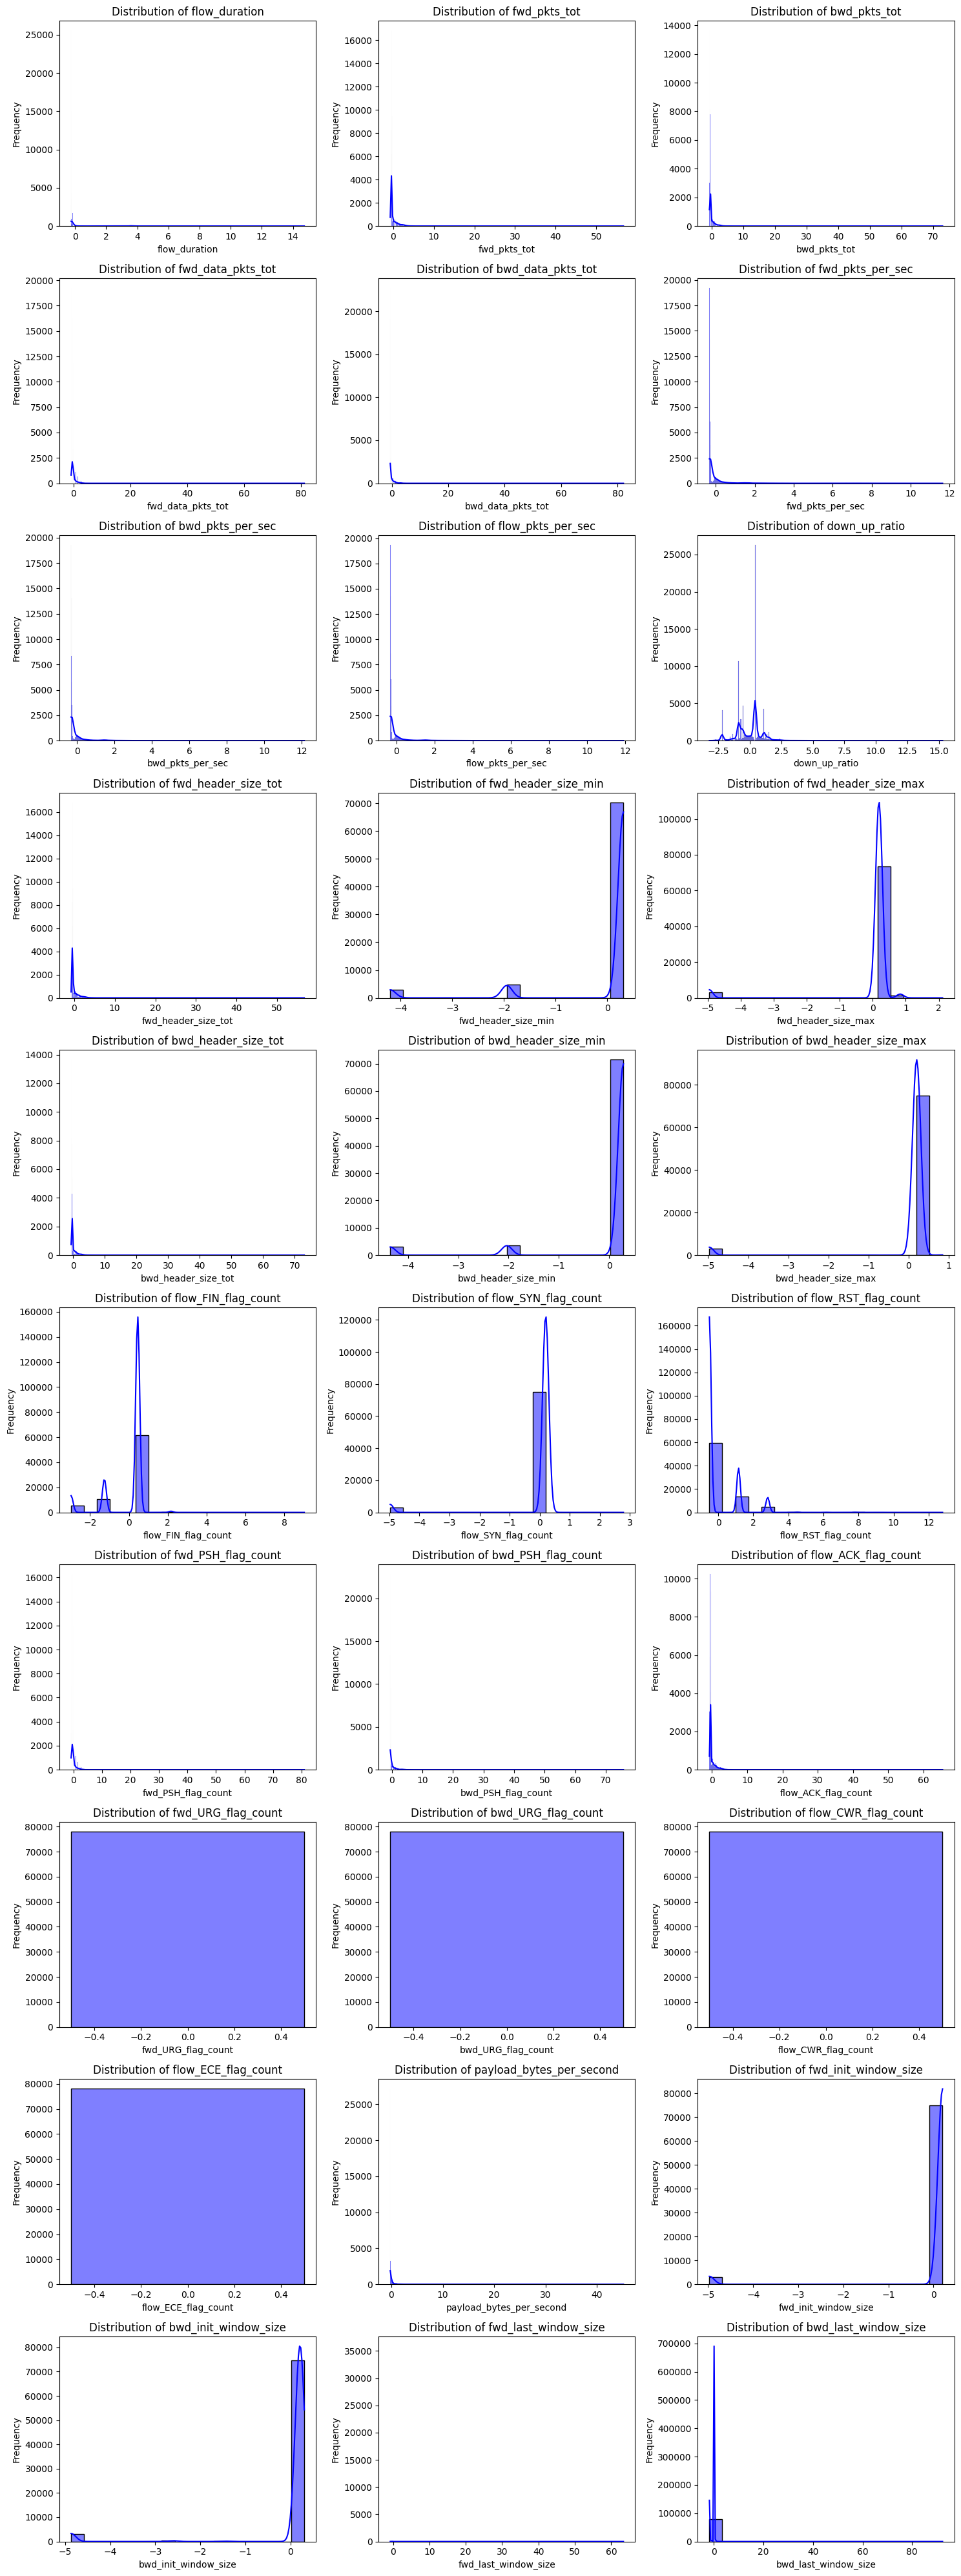

In [ ]:
plot_feature_distribution_grid(df=X, features=X.columns, color="blue", cols=3)

<a id="distribution-after-minmaxscaler-normalisation"></a>

### Distribution after MinMaxScaler Normalisation [🏠](#data-cleaning-and-preprocessing)

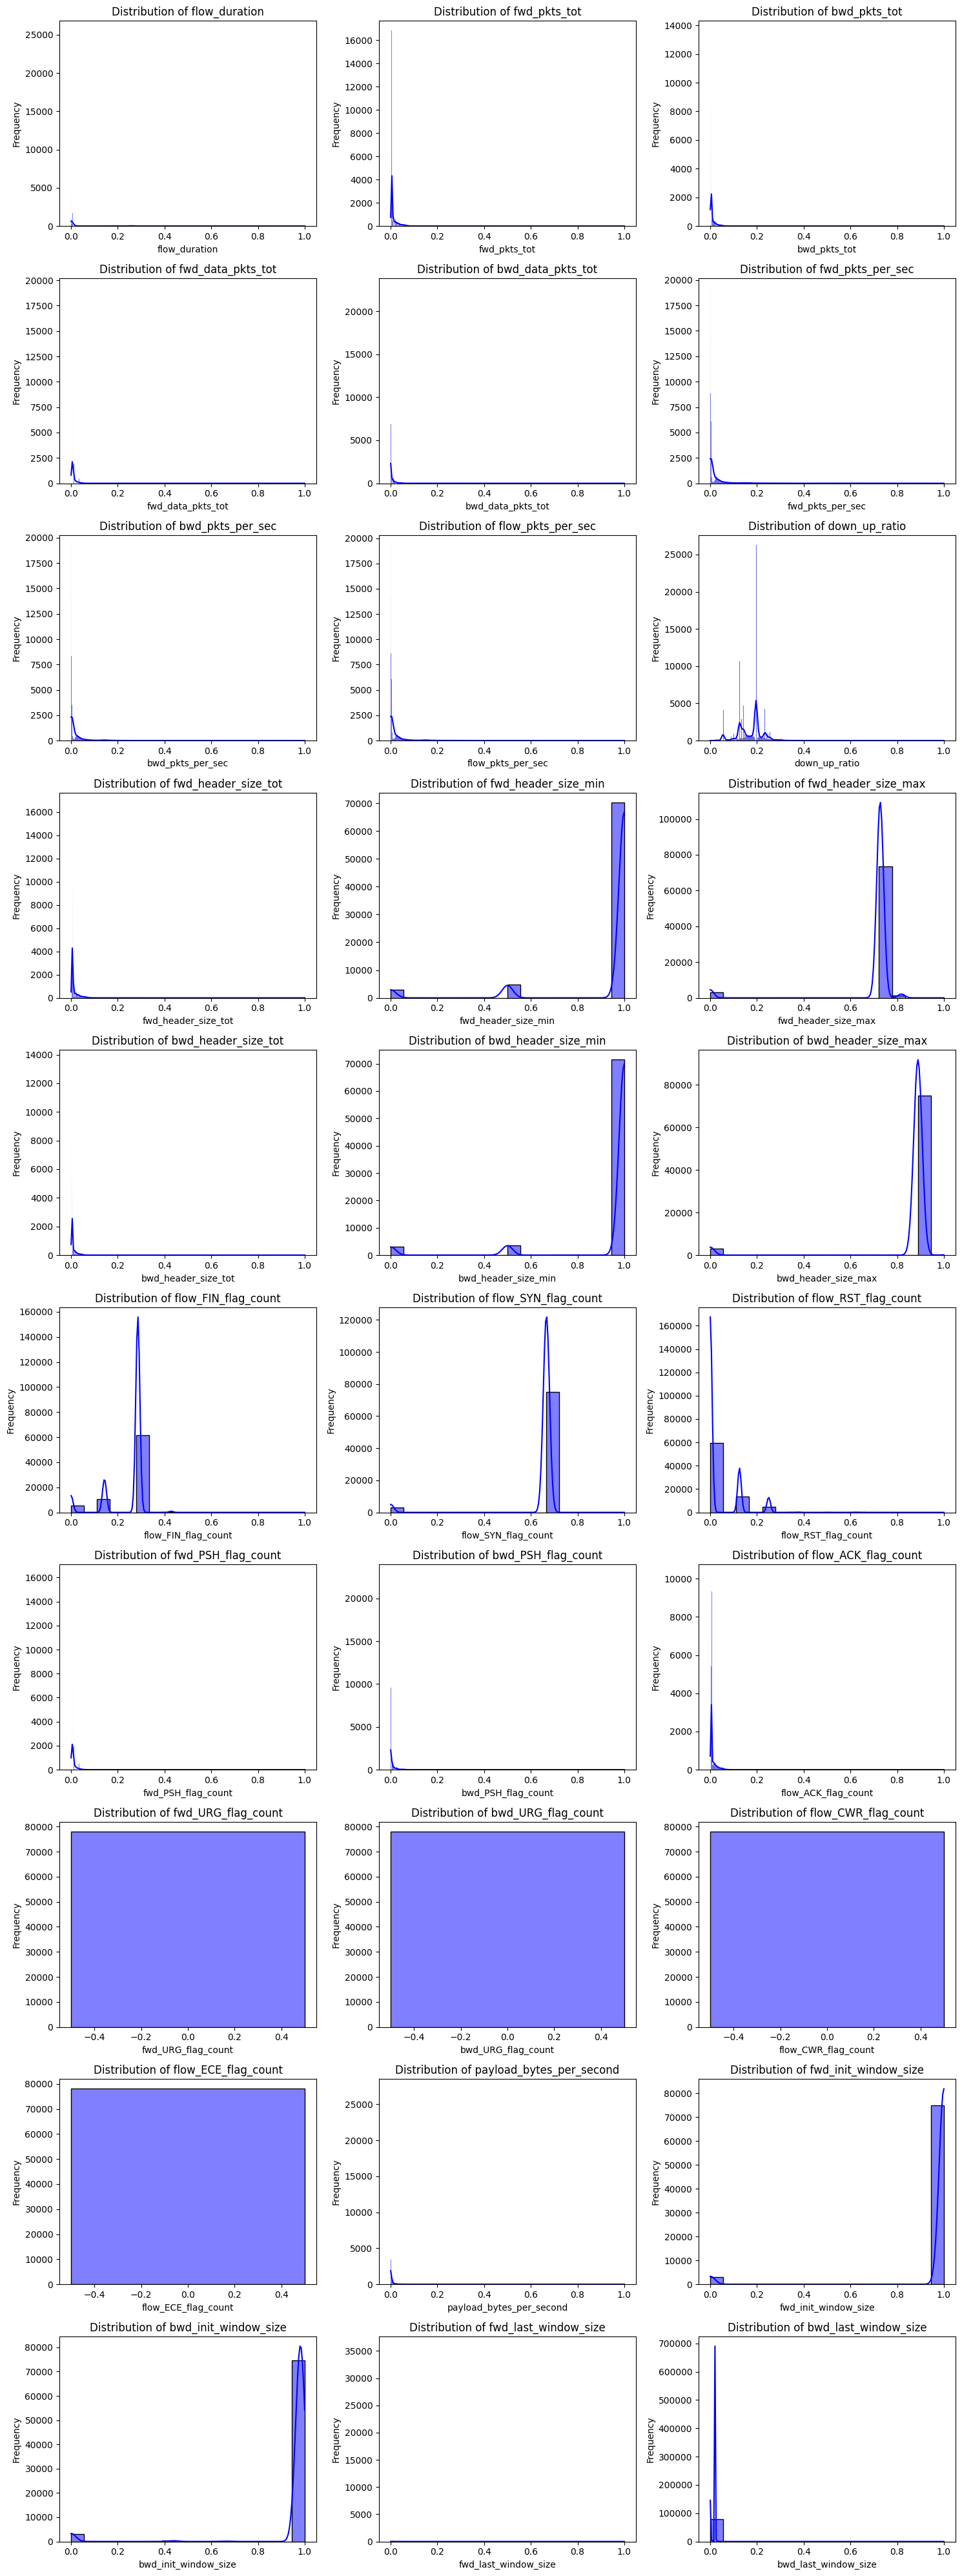

In [22]:
mm_scaler = MinMaxScaler()
X_mm_scaled = mm_scaler.fit_transform(X)
X_mm_scaled = pd.DataFrame(X_mm_scaled, columns=X.columns)

plot_feature_distribution_grid(df=X_mm_scaled, features=X_mm_scaled.columns, color="blue", cols=3)

<a id="train-and-evaluate-the-model" ></a>

### Train and Evaluate the Model [🏠](#data-cleaning-and-preprocessing)

In [11]:
X.shape

(137024, 30)

In [ ]:
# # Top 15 features based on domain knowledge and previous analysis
top_features = None  
# top_features = [
#     "flow_duration",
#     "payload_bytes_per_second",
#     "fwd_pkts_per_sec",
#     "flow_pkts_per_sec",
#     "bwd_pkts_per_sec",
#     "flow_ACK_flag_count",
#     "fwd_header_size_tot",
#     "service_http",
#     "fwd_data_pkts_tot",
#     "bwd_header_size_tot",
#     "service_ssh",
#     "service_ftp",
#     "fwd_last_window_size",
#     "bwd_last_window_size",
#     "bwd_data_pkts_tot"
# ]

# Define classifiers to evaluate
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "SVC linear": SVC(kernel='linear'),
    "SVC RBF": SVC(kernel='rbf'),
    "SVC Poly": SVC(kernel='poly'),
    "K-Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
}

In [13]:
# Set topfeatures equal to all the features in the columns of X
if top_features is None:
    top_features = X.columns.tolist()  # Use all features if no specific ones are provided
    
# Train and evaluate models
trained_clfs, performace_dict_1 = train_and_evaluate_model(
                    X, 
                    y_attack_type, 
                    top_features=top_features, 
                    classifiers=classifiers)

Training Random Forest...


ValueError: at least one array or dtype is required

<a id="dimentionality-reduced-data-for-model-training" ></a>

### Dimentionality Reduced data for model training [🏠](#data-cleaning-and-preprocessing)

In [ ]:
# x_pca = PCA(n_components=3).fit_transform(X[top_features])
# x_tsne = TSNE(n_components=3, random_state=42).fit_transform(X[top_features])
# x_umap = UMAP(n_components=3, random_state=42).fit_transform(X[top_features])

<a id="boosting-classifiers-training"></a>

### Boosting Classifiers Training [🏠](#data-cleaning-and-preprocessing)

Training XGBoost...


e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:26:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1905
           1       1.00      1.00      1.00      1967
           2       1.00      1.00      1.00      2009
           3       0.97      0.92      0.94      2090
           4       0.97      0.85      0.91      2042
           5       1.00      1.00      1.00      1955
           6       0.90      0.88      0.89      1623
           7       0.86      0.89      0.87      1723
           8       0.92      0.96      0.94      2014
           9       0.87      0.97      0.92      1892
          10       0.50      0.49      0.50      1979
          11       0.51      0.53      0.52      2018
          12       0.81      0.80      0.81      1088
          13       0.83      0.87      0.85      1316
          14       0.82      0.88      0.85       867
          15       0.90      0.83      0.86       917

    accuracy                           0.87     

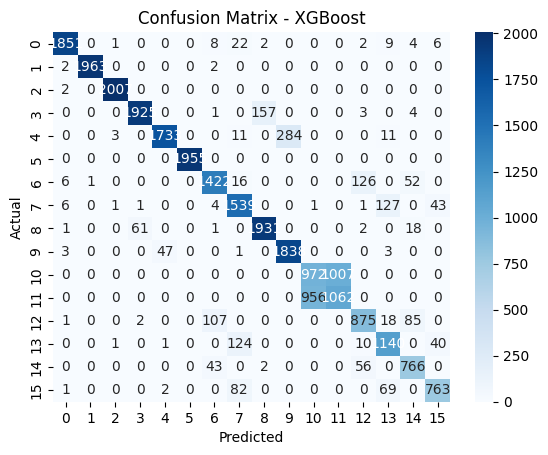

Training CatBoost...

CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1905
           1       1.00      1.00      1.00      1967
           2       0.99      1.00      0.99      2009
           3       0.97      0.90      0.93      2090
           4       0.96      0.82      0.88      2042
           5       1.00      1.00      1.00      1955
           6       0.88      0.88      0.88      1623
           7       0.85      0.89      0.87      1723
           8       0.90      0.96      0.93      2014
           9       0.84      0.96      0.90      1892
          10       0.50      0.49      0.49      1979
          11       0.51      0.51      0.51      2018
          12       0.81      0.81      0.81      1088
          13       0.81      0.87      0.84      1316
          14       0.84      0.86      0.85       867
          15       0.90      0.81      0.85       917

    accuracy              

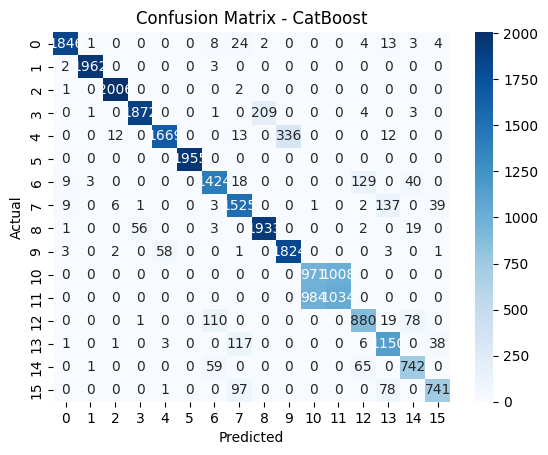

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2739
[LightGBM] [Info] Number of data points in the train set: 109619, number of used features: 15
[LightGBM] [Info] Start training from score -2.689602
[LightGBM] [Info] Start training from score -2.613702
[LightGBM] [Info] Start training from score -2.618695
[LightGBM] [Info] Start training from score -2.631415
[LightGBM] [Info] Start training from score -2.628125
[LightGBM] [Info] Start training from score -2.611960
[LightGBM] [Info] Start training from score -2.855192
[LightGBM] [Info] Start training from score -2.747251
[LightGBM] [Info] Start training from score -2.619947
[LightGBM] [Info] Start training from score -2.604530
[LightGBM] [Info] Start training from score -2.614948
[LightGBM] [Info] Start trainin

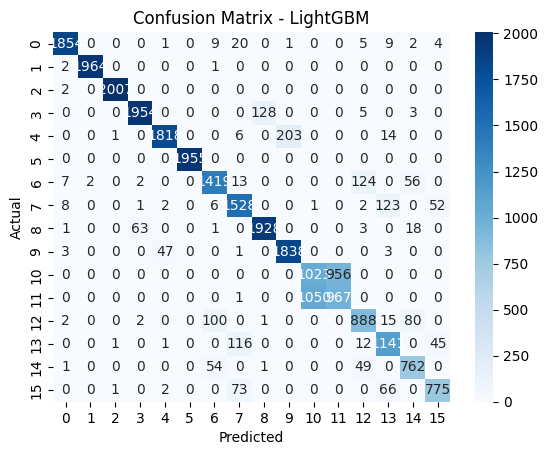

Training AdaBoost...

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1905
           1       0.00      0.00      0.00      1967
           2       0.00      0.00      0.00      2009
           3       0.24      1.00      0.38      2090
           4       0.00      0.00      0.00      2042
           5       1.00      1.00      1.00      1955
           6       0.93      0.46      0.61      1623
           7       0.15      0.99      0.25      1723
           8       0.00      0.00      0.00      2014
           9       0.00      0.00      0.00      1892
          10       0.00      0.00      0.00      1979
          11       0.50      1.00      0.67      2018
          12       0.00      0.00      0.00      1088
          13       0.00      0.00      0.00      1316
          14       0.00      0.00      0.00       867
          15       0.00      0.00      0.00       917

    accuracy              

e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set 

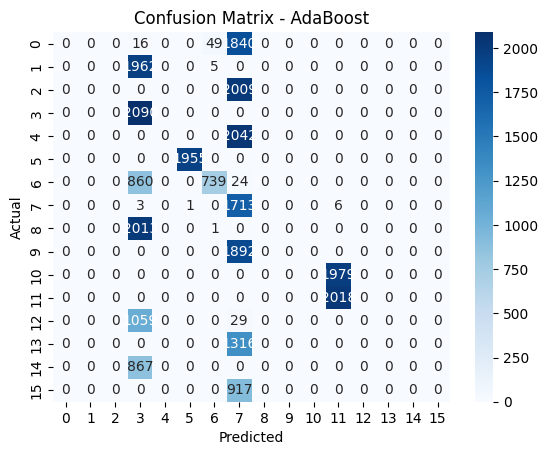

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode string labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_attack_type)

trained_xgb_clf, xgb_performance_dict = train_and_evaluate_model(
    X,
    y_encoded,
    top_features=top_features,
    classifiers={
        "XGBoost": XGBClassifier(use_label_encoder=label_encoder, eval_metric='mlogloss'),
        "CatBoost": CatBoostClassifier(verbose=0, random_seed=42),
        "LightGBM": LGBMClassifier(),
        "AdaBoost": AdaBoostClassifier()
    }
)

<a id="k-nearest-neighbour"></a>

### K-Nearest Neighbour [🏠](#data-cleaning-and-preprocessing)

In [ ]:
trained_KNN_clf, knn_performance_dict = train_and_evaluate_model(
    X,
    y_attack_type,
    top_features=top_features,
    classifiers={
        "K-Neighbors": KNeighborsClassifier(n_neighbors=5),
    }
)

<a id="performance-comparison"></a>

### Performance Comparison [🏠](#data-cleaning-and-preprocessing)

In [ ]:
performace_dict_1.update(xgb_performance_dict)

# Put the performance metrics into a DataFrame for better visualization
performance_df = pd.DataFrame(performace_dict_1).T
performance_df = performance_df.sort_values(by='f1_score', ascending=False)
print("Performance Metrics:")
print(performance_df)

Performance Metrics:
                      accuracy  f1_score  precision    recall
Random Forest         0.870462  0.870435   0.870871  0.870462
Decision Tree         0.868747  0.868585   0.868822  0.868747
XGBoost               0.866338  0.866426   0.867969  0.866338
Gradient Boosting     0.857362  0.856965   0.860323  0.857362
K-Neighbors           0.855537  0.855816   0.856465  0.855537
SVC RBF               0.809998  0.783174   0.776567  0.809998
SVC linear            0.795110  0.768362   0.766764  0.795110
Logistic Regression   0.774603  0.747557   0.738834  0.774603
SVC Poly              0.773180  0.744504   0.745883  0.773180
Gaussian Naive Bayes  0.612334  0.553080   0.627769  0.612334
AdaBoost              0.310710  0.201929   0.190654  0.310710
